<a href="https://colab.research.google.com/github/Fantiflex/Modular_Manifold_Muon/blob/main/main_vanilla_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import os
import pickle
import time

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim import AdamW
from torch.utils.data import DataLoader


from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")

%run "/content/drive/MyDrive/Colab_notebooks/EECS182_project/copy_hyperspherical_descent.ipynb"
%run "/content/drive/MyDrive/Colab_notebooks/EECS182_project/copy_Optimizers_project_182.ipynb"
# after this, the functions defined inside those notebooks are available in the current notebook

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)


OPTS = {}


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512, bias=False)
        self.fc2 = nn.Linear(512, 512, bias=False)
        self.fc3 = nn.Linear(512, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train(epochs, initial_lr, update, wd):
    model = MLP().cuda()
    criterion = nn.CrossEntropyLoss()

    if update == AdamW:
        optimizer = AdamW(model.parameters(), lr=initial_lr, weight_decay=wd)
    else:
        assert update in [manifold_muon, hyperspherical_descent, manifold_muon_general]
        optimizer = None
        if update == manifold_muon_general:
            opts = {p: ManifoldLBFGS(eta=initial_lr, history=10, eps_curv=1e-12, use_polar_impl=True)
                    for p in model.parameters()}

    steps = epochs * len(train_loader)
    step = 0

    if optimizer is None:
        for p in model.parameters():
            if update == manifold_muon_general:
                p.data = update(p.data, torch.zeros_like(p.data), eta=0.0, opt=opts[p])
            else:
                p.data = update(p.data, torch.zeros_like(p.data), eta=0.0)

    epoch_losses = []
    epoch_times = []

    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            model.zero_grad()
            loss.backward()
            lr = initial_lr * (1 - step / steps)
            with torch.no_grad():
                if optimizer is None:
                    if update == manifold_muon_general:
                        # 1) Finaliser la paire (s,y) précédente avec le gradient courant
                        for p in model.parameters():
                            if getattr(opts[p], "last", None) is not None:
                                opts[p].update(p.grad)

                        # 2) Nouveau pas L-BFGS (note le opt=..., et p.data)
                        for p in model.parameters():
                            p.data = update(p.data, p.grad, eta=lr, opt=opts[p])
                    else:
                        # Cas stateless : manifold_muon, hyperspherical_descent
                        for p in model.parameters():
                            p.data = update(p.data, p.grad, eta=lr)
                else:
                    # Optimiseur PyTorch (AdamW)
                    optimizer.step()

            step += 1
            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        end_time = time.time()
        epoch_loss = running_loss / len(train_loader)
        epoch_time = end_time - start_time
        epoch_losses.append(epoch_loss)
        epoch_times.append(epoch_time)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}, Time: {epoch_time:.4f} seconds")
    return model, epoch_losses, epoch_times


def eval(model):
    # Test the model
    model.eval()
    with torch.no_grad():
        accs = []
        for dataloader in [test_loader, train_loader]:
            correct = 0
            total = 0
            for images, labels in dataloader:
                images = images.cuda()
                labels = labels.cuda()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accs.append(100 * correct / total)

    print(f"Accuracy of the network on the {len(test_loader.dataset)} test images: {accs[0]} %")
    print(f"Accuracy of the network on the {len(train_loader.dataset)} train images: {accs[1]} %")
    return accs


def weight_stats(model):
    singular_values = []
    norms = []
    for p in model.parameters():
        u, s, v = torch.svd(p)
        singular_values.append(s)
        norms.append(p.norm())
    return singular_values, norms


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Train a model on CIFAR-10.")
    parser.add_argument("--epochs", type=int, default=5, help="Number of epochs to train for.")
    parser.add_argument("--lr", type=float, default=0.005, help="Initial learning rate.")
    parser.add_argument("--update", type=str, default="manifold_muon_general",
                        choices=["manifold_muon", "hyperspherical_descent", "adam", "manifold_muon_general"],
                        help="Update rule to use.")
    parser.add_argument("--seed", type=int, default=42, help="Seed for the random number generator.")
    parser.add_argument("--wd", type=float, default=0.0, help="Weight decay for AdamW.")
    args = parser.parse_args([])

    # determinism flags
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    update_rules = {
        "manifold_muon": manifold_muon,
        "hyperspherical_descent": hyperspherical_descent,
        "adam": AdamW,
        "manifold_muon_general": manifold_muon_general
    }

    update = update_rules[args.update]

    print(f"Training with: {args.update}")
    print(f"Epochs: {args.epochs} --- LR: {args.lr}", f"--- WD: {args.wd}" if args.update == "adam" else "")
    print(f"Number_of_layer: 3")
    print(f"Number_of_epochs: 5")

    model, epoch_losses, epoch_times = train(
        epochs=args.epochs,
        initial_lr=args.lr,
        update=update,
        wd=args.wd
    )
    test_acc, train_acc = eval(model)
    singular_values, norms = weight_stats(model)

    results = {
        "epochs": args.epochs,
        "lr": args.lr,
        "seed": args.seed,
        "wd": args.wd,
        "update": args.update,
        "epoch_losses": epoch_losses,
        "epoch_times": epoch_times,
        "test_acc": test_acc,
        "train_acc": train_acc,
        "singular_values": singular_values,
        "norms": norms
    }

    filename = f"update-{args.update}-lr-{args.lr}-wd-{args.wd}-seed-{args.seed}.pkl"
    os.makedirs("results", exist_ok=True)

    print(f"Saving results to {os.path.join('results', filename)}")
    with open(os.path.join("results", filename), "wb") as f:
        pickle.dump(results, f)
    print(f"Results saved to {os.path.join('results', filename)}")


100%|██████████| 170M/170M [00:04<00:00, 40.7MB/s]


Training with: manifold_muon_general
Epochs: 5 --- LR: 0.005 
Number_of_layer: 3
Number_of_epochs: 5


TypeError: ManifoldLBFGS.__init__() got an unexpected keyword argument 'use_polar_impl'

First, uninstall the current PyTorch version. This command will prompt you for confirmation, so make sure to type `y` and press Enter when asked.

In [ ]:
!pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126


Next, install the desired PyTorch version. You can find the installation command for specific versions and CUDA compatibility on the official PyTorch website (`pytorch.org/get-started/locally/`).

For example, to install the latest stable version with CUDA 11.8 (common in Colab), you might use something like this:

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 117.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 118.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 828.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.2/9

After running these commands, you should restart the runtime (`Runtime > Restart runtime` from the menu) for the changes to take effect. Then, you can verify the installed version:

In [ ]:
import torch
print(torch.__version__)

2.7.1+cu118


Update: manifold_muon | LR: 0.001 | Seed: 0
Epoch 1, Loss: 2.3799151352473666, Time: 111.5702 seconds
Epoch 2, Loss: 2.3334009160800857, Time: 111.0630 seconds
Epoch 3, Loss: 2.3252911519031136, Time: 110.9783 seconds
Accuracy of the network on the 10000 test images: 14.09 %
Accuracy of the network on the 50000 train images: 13.77 %
Update: manifold_muon | LR: 0.01 | Seed: 0
Epoch 1, Loss: 1.9065836546372394, Time: 111.4951 seconds
Epoch 2, Loss: 1.6494729543218807, Time: 111.0908 seconds
Epoch 3, Loss: 1.6023327720408538, Time: 111.2081 seconds
Accuracy of the network on the 10000 test images: 44.33 %
Accuracy of the network on the 50000 train images: 46.944 %
Update: manifold_muon | LR: 0.05 | Seed: 0
Epoch 1, Loss: 1.6480563124831842, Time: 111.0041 seconds
Epoch 2, Loss: 1.2951180545651182, Time: 111.2478 seconds
Epoch 3, Loss: 1.1570173964208486, Time: 110.7896 seconds
Accuracy of the network on the 10000 test images: 52.9 %
Accuracy of the network on the 50000 train images: 67.14

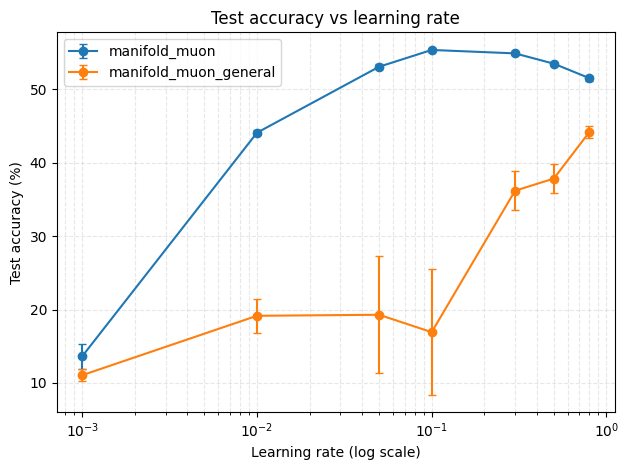

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch

# ----------------------------------------------------------------------
# Config
# ----------------------------------------------------------------------
LR_LIST = [0.001, 0.01, 0.05,
           0.1, 0.3, 0.5, 0.8]

SEEDS = [0, 15, 42]
EPOCHS =  3 # adapte si tu veux
RESULTS_DIR = "results_sweep"  # pour ne pas mélanger avec l'autre script

UPDATES = {
    "manifold_muon": manifold_muon,
    "manifold_muon_general": manifold_muon_general,
}

os.makedirs(RESULTS_DIR, exist_ok=True)

# Pour stocker les test accuracies: {update: {lr: [acc_seed1, acc_seed2, ...]}}
sweep_acc = {name: {} for name in UPDATES.keys()}

# ----------------------------------------------------------------------
# Sweep LR × seeds × updates
# ----------------------------------------------------------------------
for update_name, update_fn in UPDATES.items():
    for seed in SEEDS:
        # Déterminisme
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        for lr in LR_LIST:
            print("=" * 80)
            print(f"Update: {update_name} | LR: {lr} | Seed: {seed}")
            print("=" * 80)

            # Entraînement
            model, epoch_losses, epoch_times = train(
                epochs=EPOCHS,
                initial_lr=lr,
                update=update_fn,
                wd=0.0,  # pas de weight decay pour ces updates
            )

            # Évaluation (la fonction eval renvoie test puis train)
            test_acc, train_acc = eval(model)

            # Sauvegarde brute si tu veux rejouer ou analyser plus tard
            results = {
                "epochs": EPOCHS,
                "lr": lr,
                "seed": seed,
                "wd": 0.0,
                "update": update_name,
                "epoch_losses": epoch_losses,
                "epoch_times": epoch_times,
                "test_acc": test_acc,
                "train_acc": train_acc,
            }
            filename = f"update-{update_name}-lr-{lr}-seed-{seed}.pkl"
            filepath = os.path.join(RESULTS_DIR, filename)
            with open(filepath, "wb") as f:
                pickle.dump(results, f)

            # Stockage pour le plot
            if lr not in sweep_acc[update_name]:
                sweep_acc[update_name][lr] = []
            sweep_acc[update_name][lr].append(test_acc)

# ----------------------------------------------------------------------
# Plot Test Accuracy vs Learning Rate (log-scale)
# ----------------------------------------------------------------------
plt.figure()

for update_name in UPDATES.keys():
    if len(sweep_acc[update_name]) == 0:
        continue

    lrs = sorted(sweep_acc[update_name].keys())
    lrs_arr = np.array(lrs, dtype=float)

    means = []
    stds = []
    for lr in lrs:
        vals = np.array(sweep_acc[update_name][lr], dtype=float)
        means.append(vals.mean())
        stds.append(vals.std())
    means = np.array(means)
    stds = np.array(stds)

    plt.errorbar(
        lrs_arr,
        means,
        yerr=stds,
        marker="o",
        linestyle="-",
        capsize=3,
        label=update_name,
    )

plt.xscale("log")  # échelle log pour bien voir le sweep 1e-3 → 10
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Test accuracy (%)")
plt.title("Test accuracy vs learning rate")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
